<center>
<img src="https://habrastorage.org/files/fd4/502/43d/fd450243dd604b81b9713213a247aa20.jpg">
## Open Machine Learning Course [mlcourse.ai](https://mlcourse.ai)
<center>

Author: Vitaly Radchenko (@vradchenko). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

# <center>Assignment # 5 (demo)</center>
## <center>Logistic Regression and Random Forest in the credit scoring problem</center>  

In this assignment, you will build models and answer questions using data on credit scoring.

Please write your code in the cells with the "Your code here" placeholder. Then, answer the questions in the [form](https://docs.google.com/forms/d/1gKt0DA4So8ohKAHZNCk58ezvg7K_tik26d9QND7WC6M/edit).

Let's start with a warm-up exercise.

**Question 1.** There are 5 jurors in a courtroom. Each of them can correctly identify the guilt of the defendant with 70% probability, independent of one another. What is the probability that the jurors will jointly reach the correct verdict if the final decision is by majority vote?

1. 70.00%
2. 83.20%
3. **83.70%**
4. 87.50%

**Condorcet's jury theorem (1784):**
If each member of the jury makes an independent judgment and the probability of the correct decision by each juror is more than 0.5, then the probability of the correct decision by the whole jury increases with the total number of jurors and tends to one.

$\large \mu = \sum_{i=m}^N {N \choose i}p^i (1-p)^{n-i} = 10*0.7^3*0.3^2 + 5*0.7^4*0.3 + 0.7^5 \approx 0.837$

It can be seen that if $\large p>0.5$, then $\large \mu>p$. In addition, if $\large N→\infty$, then $\large μ→1$.

Great! Let's move on to machine learning.

## Credit scoring problem setup

#### Problem

Predict whether the customer will repay their credit within 90 days. This is a binary classification problem; we will assign customers into good or bad categories based on our prediction.

#### Data description

| Feature | Variable Type | Value Type | Description |
|:--------|:--------------|:-----------|:------------|
| age | Input Feature | integer | Customer age |
| DebtRatio | Input Feature | real | Total monthly loan payments (loan, alimony, etc.) / Total monthly income percentage |
| NumberOfTime30-59DaysPastDueNotWorse | Input Feature | integer | The number of cases when client has overdue 30-59 days (not worse) on other loans during the last 2 years |
| NumberOfTimes90DaysLate | Input Feature | integer | Number of cases when customer had 90+dpd overdue on other credits |
| NumberOfTime60-89DaysPastDueNotWorse | Input Feature | integer | Number of cased when customer has 60-89dpd (not worse) during the last 2 years |
| NumberOfDependents | Input Feature | integer | The number of customer dependents |
| SeriousDlqin2yrs | Target Variable | binary: <br>0 or 1 | Customer hasn't paid the loan debt within 90 days |


Let's set up our environment:

In [1]:
# Disable warnings in Anaconda
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

%matplotlib inline

In [2]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8

Let's write the function that will replace *NaN* values with the median for each column.

In [3]:
def fill_nan(table):
    for col in table.columns:
        table[col] = table[col].fillna(table[col].median())
    return table   

Now, read the data:

In [4]:
data = pd.read_csv('../input/credit_scoring_sample.csv')
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


Look at the variable types:

In [5]:
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Check the class balance:

Distribution of the target:


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

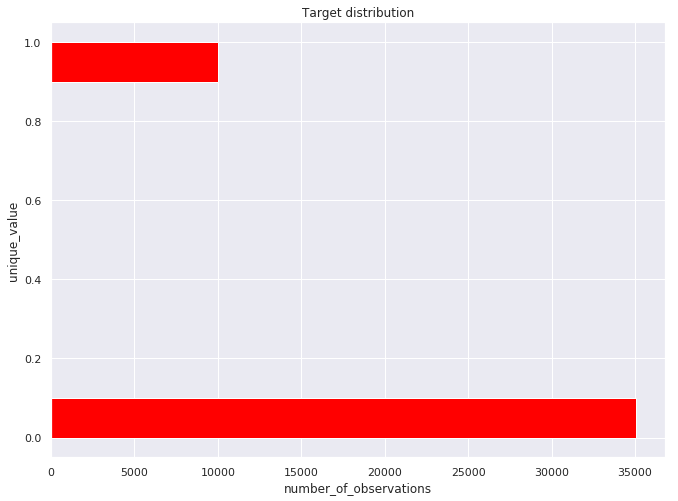

In [6]:
ax = data['SeriousDlqin2yrs'].hist(orientation='horizontal', color='red')
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print('Distribution of the target:')
data['SeriousDlqin2yrs'].value_counts()/data.shape[0]

Separate the input variable names by excluding the target:

In [7]:
independent_columns_names = [x for x in data if x != 'SeriousDlqin2yrs']
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

Apply the function to replace *NaN* values:

In [8]:
table = fill_nan(data)

Separate the target variable and input features:

In [9]:
X = table[independent_columns_names]
y = table['SeriousDlqin2yrs']

## Bootstrapping

**Question 2.** Make an interval estimate of the average age for the customers who delayed repayment at the 90% confidence level. Use the example from the article as reference, if needed. Also, use `np.random.seed(0)` as before. What is the resulting interval estimate?

1. 52.59 – 52.86
2. 45.71 – 46.13
3. **45.68 – 46.17**
4. 52.56 – 52.88

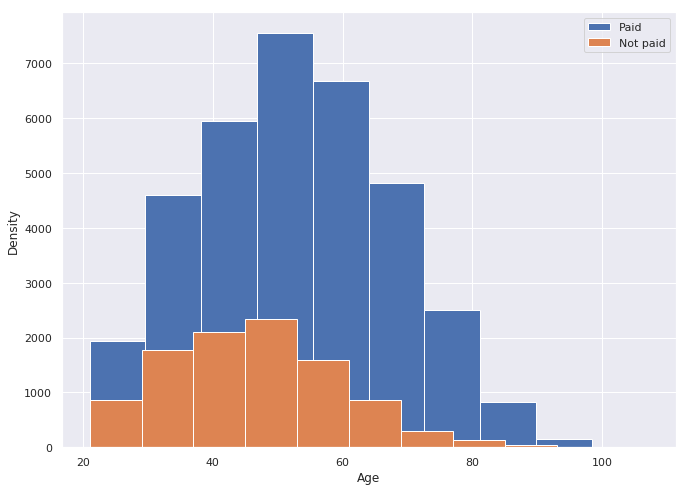

In [10]:
data.loc[data['SeriousDlqin2yrs'] == False,
                 'age'].hist(label='Paid')
data.loc[data['SeriousDlqin2yrs'] == True,
                 'age'].hist(label='Not paid')

plt.xlabel('Age')
plt.ylabel('Density')
plt.legend()
plt.show()

In [11]:
def get_bootstrap_samples(data, n_samples):
    """Generate bootstrap samples using the bootstrap method."""
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    """Produce an interval estimate."""
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

# Save the data about the customers to split the dataset
paid_loan = data.loc[data['SeriousDlqin2yrs'] == False, 'age'].values
not_paid_loan = data.loc[data['SeriousDlqin2yrs'] == True, 'age'].values

# Set the seed for reproducibility of the results
np.random.seed(0)

# Generate the samples using bootstrapping and calculate the mean for each of them
paid_loan_scores = [np.mean(sample) 
                       for sample in get_bootstrap_samples(paid_loan, 1000)]
not_paid_loan_scores = [np.mean(sample) 
                       for sample in get_bootstrap_samples(not_paid_loan, 1000)]

# Print the resulting interval estimates
print("Customers who returned loan: mean 90% confidence interval", stat_intervals(paid_loan_scores, 0.1))
print("Customers who did not pay back: mean 90% confidence interval", stat_intervals(not_paid_loan_scores, 0.1))

Customers who returned loan: mean 90% confidence interval [52.59069983 52.85581385]
Customers who did not pay back: mean 90% confidence interval [45.70569021 46.14615001]


## Logistic regression

Let's set up to use logistic regression:

In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

Now, we will create a `LogisticRegression` model and use `class_weight='balanced'` to make up for our unbalanced classes.

In [13]:
lr = LogisticRegression(random_state=5, class_weight='balanced')

Let's try to find the best regularization coefficient, which is the coefficient `C` for logistic regression. Then, we will have an optimal model that is not overfit and is a good predictor of the target variable.

In [14]:
parameters = {'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)}

In order to find the optimal value of `C`, let's apply stratified 5-fold validation and look at the *ROC AUC* against different values of the parameter `C`. Use the `StratifiedKFold` function for this: 

In [15]:
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

One of the important metrics of model quality is the *Area Under the Curve (AUC)*. *ROC AUC* varies from 0 to 1. The closer ROC AUC is to 1, the better the quality of the classification model.

**Question 3.** Perform a *Grid Search* with the scoring metric "roc_auc" for the parameter `C`. Which value of the parameter `C` is optimal? 

1. 0.0001
2. **0.001**
3. 0.01
4. 0.1
5. 1
6. 10

In [16]:
%%time

gs = GridSearchCV(lr, parameters, cv=skfold, scoring='roc_auc', n_jobs=-1, verbose=1)
gs.fit(X, y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.2s finished


CPU times: user 652 ms, sys: 71.1 ms, total: 723 ms
Wall time: 10.7 s


In [17]:
gs.best_params_, gs.best_score_

({'C': 0.001}, 0.795409411236062)

**Question 4.** Can we consider the best model stable? The model is *stable* if the standard deviation on validation is less than 0.5%. Save the *ROC AUC* value of the best model; it will be useful for the following tasks.

1. Yes
2. **No**

In [18]:
gs.cv_results_['std_test_score'] * 100

array([0.53116918, 0.63574719, 0.81829956, 0.826878  , 0.83230918,
       0.83297331])

No model is stable (std_dev is greater than 0.5%), even model with best score (std_dev = 0.63%)

* ## Feature importance

**Question 5.** *Feature importance* is defined by the absolute value of its corresponding coefficient. First, you need to normalize all of the feature values so that it will be valid to compare them. What is the most important feature for the best logistic regression model?

1. age
2. **NumberOfTime30-59DaysPastDueNotWorse**
3. DebtRatio
4. NumberOfTimes90DaysLate
5. NumberOfTime60-89DaysPastDueNotWorse
6. MonthlyIncome
7. NumberOfDependents

Feature: age, Score: 0.41630
Feature: NumberOfTime30-59DaysPastDueNotWorse, Score: 0.72400
Feature: DebtRatio, Score: 0.02408
Feature: NumberOfTimes90DaysLate, Score: 0.51767
Feature: NumberOfTime60-89DaysPastDueNotWorse, Score: 0.19473
Feature: MonthlyIncome, Score: 0.16286
Feature: NumberOfDependents, Score: 0.10133


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


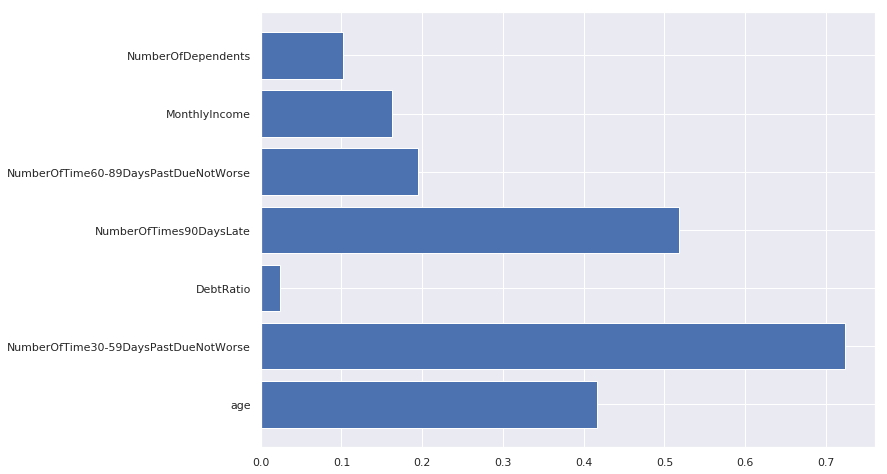

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

clf = LogisticRegression(C=0.001, random_state=5, class_weight='balanced')
clf.fit(X_scaled, y)

importance = clf.coef_[0]

for feat, imp in list(zip(X.columns, np.abs(importance))):
    print('Feature: %s, Score: %.5f' % (feat, imp))

plt.barh(X.columns, np.abs(importance))
plt.show()

**Question 6.** Calculate how much `DebtRatio` affects our prediction using the [softmax function](https://en.wikipedia.org/wiki/Softmax_function). What is its value?

1. 0.38
2. -0.02
3. **0.11**
4. 0.24

In [20]:
np.exp(clf.coef_[0][2]) / np.sum(np.exp(clf.coef_[0])) 

0.11420536719928262

**Question 7.** Let's see how we can interpret the impact of our features. For this, recalculate the logistic regression with absolute values, that is without scaling. Next, modify the customer's age by adding 20 years, keeping the other features unchanged. How many times will the chance that the customer will not repay their debt increase? You can find an example of the theoretical calculation [here](https://www.unm.edu/~schrader/biostat/bio2/Spr06/lec11.pdf).

1. -0.01
2. **0.70**
3. 8.32
4. 0.66

In [21]:
lr = LogisticRegression(C=0.001, random_state=5, class_weight='balanced')
lr.fit(X, y)

importance = lr.coef_[0]

for feat, imp in list(zip(X.columns, np.abs(importance))):
    print('Feature: %s, Score: %.5f' % (feat, imp))

Feature: age, Score: 0.01819
Feature: NumberOfTime30-59DaysPastDueNotWorse, Score: 0.48235
Feature: DebtRatio, Score: 0.00001
Feature: NumberOfTimes90DaysLate, Score: 0.43031
Feature: NumberOfTime60-89DaysPastDueNotWorse, Score: 0.06596
Feature: MonthlyIncome, Score: 0.00001
Feature: NumberOfDependents, Score: 0.11536


In [22]:
np.exp(lr.coef_[0][0]*20)

0.6950957705271931

## Random Forest

Import the Random Forest classifier:

In [23]:
from sklearn.ensemble import RandomForestClassifier

Initialize Random Forest with 100 trees and balance target classes:

In [24]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42, class_weight='balanced')

We will search for the best parameters among the following values:

In [25]:
parameters = {'max_features': [1, 2, 4], 'min_samples_leaf': [3, 5, 7, 9], 'max_depth': [5, 10, 15]}

Also, we will use the stratified k-fold validation again. You should still have the `skf` variable.

**Question 8.** How much higher is the *ROC AUC* of the best random forest model than that of the best logistic regression on validation?

1. **0.04**
2. 0.03
3. 0.02
4. 0.01

In [26]:
%%time

gs = GridSearchCV(rf, parameters, cv=skfold, scoring='roc_auc', n_jobs=-1, verbose=1)
gs.fit(X, y)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  4.2min finished


CPU times: user 6.03 s, sys: 104 ms, total: 6.13 s
Wall time: 4min 10s


In [27]:
gs.best_params_, gs.best_score_

({'max_depth': 10, 'max_features': 2, 'min_samples_leaf': 7},
 0.8350557986441058)

**Question 9.** What feature has the weakest impact in the Random Forest model?

1. age
2. NumberOfTime30-59DaysPastDueNotWorse
3. DebtRatio
4. NumberOfTimes90DaysLate
5. NumberOfTime60-89DaysPastDueNotWorse
6. MonthlyIncome
7. **NumberOfDependents**

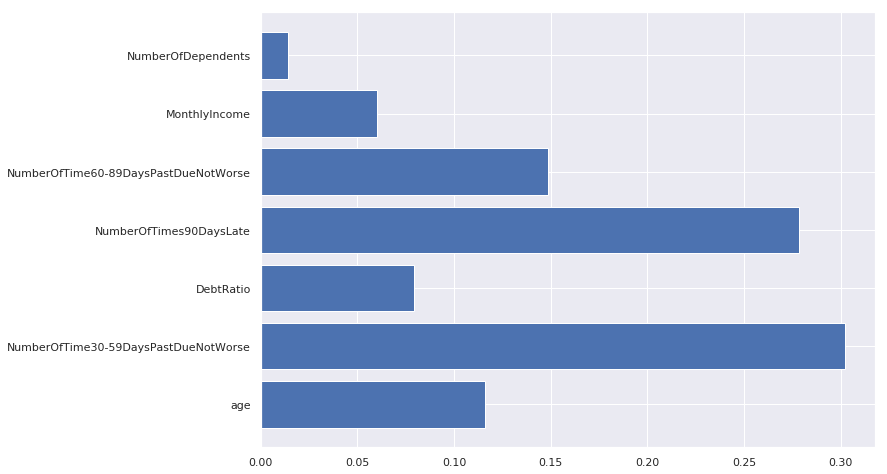

CPU times: user 5.27 s, sys: 352 ms, total: 5.62 s
Wall time: 1.84 s


In [28]:
%%time

rf = RandomForestClassifier(n_estimators=100, max_depth=10, max_features=2, min_samples_leaf=7, n_jobs=-1, random_state=42, class_weight='balanced')
rf.fit(X, y)

plt.barh(X.columns, rf.feature_importances_)
plt.show()

**Question 10.** What is the most significant advantage of using *Logistic Regression* versus *Random Forest* for this problem?

1. Spent less time for model fitting;
2. Fewer variables to iterate;
3. **Feature interpretability;**
4. Linear properties of the algorithm.

The most significant advntage of Logistic Regression (Linear Models) is that we can interpret the feature coefficient - a direct impact on the model prediction

## Bagging

Import modules and set up the parameters for bagging:

In [29]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV

parameters = {'max_features': [2, 3, 4], 'max_samples': [0.5, 0.7, 0.9], 
              'base_estimator__C': [0.0001, 0.001, 0.01, 1, 10, 100]}

**Question 11.** Fit a bagging classifier with `random_state=42`. For the base classifiers, use 100 logistic regressors and use `RandomizedSearchCV` instead of `GridSearchCV`. It will take a lot of time to iterate over all 54 variants, so set the maximum number of iterations for `RandomizedSearchCV` to 20. Don't forget to set the parameters `cv` and `random_state=1`. What is the best *ROC AUC* you achieve?

1. **80.75%**
2. 80.12%
3. 79.62%
4. 76.50%

In [30]:
%%time

bag_clf = BaggingClassifier(LogisticRegression(class_weight='balanced'),
                       n_estimators=100, random_state=42)

gs = RandomizedSearchCV(bag_clf, parameters, scoring='roc_auc', cv=skfold, 
                        n_iter=20, random_state=1, n_jobs=-1, verbose=1)
gs.fit(X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.7min finished


CPU times: user 11.4 s, sys: 70.9 ms, total: 11.4 s
Wall time: 8min 53s


In [31]:
gs.best_params_, gs.best_score_

({'max_samples': 0.7, 'max_features': 2, 'base_estimator__C': 0.001},
 0.8076172570918905)

**Question 12.** Give an interpretation of the best parameters for bagging. Why are these values of `max_features` and `max_samples` the best?

1. For bagging it's important to use as few features as possible;
2. Bagging works better on small samples;
3. **Less correlation between single models;**
4. The higher the number of features, the lower the loss of information.

Random Forest and Bagging work better if base algorithms are less correlated between each other, if there are too many correlated features in base log reg models, then final model deteriorates in quality, thus it select to choose from only 2 best features on subsamples of original data.